In [ ]:
pip install dedupe

In [25]:
import requests
import pandas as pd
from io import BytesIO
import dedupe
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score

# url = "https://cise.ufl.edu/~cgrant/files/er/musicbrainz_200k.csv"
url = "https://cise.ufl.edu/~cgrant/files/er/musicbrainz_20k.csv"

res = requests.get(url)
df = pd.read_csv(BytesIO(res.content))

# Check the shape of the dataset
df=df.head(1500)
df.shape

(1500, 12)

In [26]:
# Filter to English records (using your provided logic)
english_cids = df[
    df.language.str.lower().str.contains("^en|^eg", na=False)
].CID.unique()

df = df[df.CID.isin(english_cids)].reset_index(drop=True)

In [27]:
df

,TID,CID,CTID,SourceID,id,number,title,length,artist,album,year,language
0,3,2,1,2,MBox38440522-HH,17,Action PAINTING! - Mustard Gas,129,NaN,There and Back Again Lane,95,English
1,4,3,1,5,4489993,10,Your Grace,unk.,Kathy Troccoli,Comfort,2005,English
2,5,4,1,5,10339621,2,Well You Needn't,321266,Ernie Stadler Jazz Quintet,First Down,2010,English
3,6,5,1,3,49425110MB-01,6,"Try (acoustic) - 2008-02-15: Le Grand Rex, Par...",NaN,Neil Young,NaN,NaN,English
4,7,2136,3,2,MBox28675636-HH,11,Bruce Maginnis - Sttreet Hype,177,NaN,Groove City,05,English
...,...,...,...,...,...,...,...,...,...,...,...,...
820,1491,784,1,3,31004115MB-01,8,I Hate the Sun - Hate/Human,4. 25,Cyruss,NaN,'05,English
821,1494,691,2,3,31619620MB-01,12,I Don't Wanna See - The Gladiators Anthem,NaN,Mr. Drastick,NaN,'08,English
822,1495,5414,2,5,4228347,6,Honey Please Can't Ya See,195933,Barry White,Barry White & Marvin Gaye,2002,English
823,1496,786,1,5,5706037,17,Canzon per sonare no. 1 'La spiritata',196000,GIOVANNI Gabrieli,"The Chicago Brass Ensemble, The Boston Brass E...",NaN,English


In [32]:
# Modify your preprocessing to handle empty strings
for col in ["title", "artist", "album"]:
    df[col] = (
        df[col]
        .fillna("MISSING")  # Replace NaN with "MISSING" instead of empty string
        .str.lower()
        .replace("[^a-z0-9]", " ", regex=True)
        .replace(" +", " ", regex=True)
        .str.strip()
    )
    # Replace any resulting empty strings after processing
    df[col] = df[col].replace("", "MISSING")

# For number field, handle it separately
df["number"] = df["number"].fillna("MISSING")
df.loc[df.number != "MISSING", "number"] = (
    df[df.number != "MISSING"]
    .number.replace("[^0-9]", "", regex=True)
    .apply(lambda x: str(int(x)) if len(x) > 0 else "MISSING")
)
df["number"] = df["number"].replace("", "MISSING")

# Create your records
records = {}
for idx, row in df.iterrows():
    records[idx] = {
        'title': row['title'],
        'artist': row['artist'],
        'album': row['album'],
        'number': row['number']
    }

# Use your original fields definition
from dedupe.variables import String, Exact
fields = [
    String("title"),
    String("artist"),
    String("album"),
    Exact("number")
]

# Then initialize and prepare training
deduper = dedupe.Dedupe(fields)
deduper.prepare_training(records, sample_size=1500)

In [38]:
# After preparing training
deduper.prepare_training(records, sample_size=1500)

# Interactive training part
print("Starting active learning...")

# Create training pairs with the actual record data
labeled_examples = {
    'match': [],
    'distinct': []
}

# Find some matches (records with same CID)
cids = df['CID'].to_dict()
cid_to_records = defaultdict(list)
for record_id, cid in cids.items():
    cid_to_records[cid].append(record_id)

# Get 5 matching pairs (if available)
for cid, record_ids in cid_to_records.items():
    if len(record_ids) >= 2:
        pairs = [(record_ids[i], record_ids[j]) 
                for i in range(len(record_ids)) 
                for j in range(i+1, len(record_ids))]
        if pairs:
            for pair in sample(pairs, min(5, len(pairs))):
                record1, record2 = pair
                # Use the actual dictionaries from records
                labeled_examples['match'].append((records[record1], records[record2]))
            if len(labeled_examples['match']) >= 5:
                break

# Get 5 distinct pairs (records with different CIDs)
cid_list = list(cid_to_records.keys())
if len(cid_list) >= 2:
    for _ in range(5):
        cid1, cid2 = sample(cid_list, 2)
        if cid_to_records[cid1] and cid_to_records[cid2]:
            record1_id = sample(cid_to_records[cid1], 1)[0]
            record2_id = sample(cid_to_records[cid2], 1)[0]
            # Use the actual dictionaries from records
            labeled_examples['distinct'].append((records[record1_id], records[record2_id]))

# Make sure we have at least one match and one distinct example
if not labeled_examples['match'] or not labeled_examples['distinct']:
    print("Warning: Not enough examples found. Dedupe needs at least one match and one distinct example.")
    # Create a couple of examples manually if needed
    # This is just a fallback

print(f"Training with {len(labeled_examples['match'])} matches and {len(labeled_examples['distinct'])} distinct examples")

# Add the training data
deduper.mark_pairs(labeled_examples)

# Train the model
print("Training the model...")
deduper.train()


# Rest of your code for predicted clusters and evaluation...

Starting active learning...
Training with 5 matches and 5 distinct examples
Training the model...


In [39]:
# After successful training (deduper.train() has completed)
# Step 5: Cluster the records
clustered_dupes = deduper.partition(records, threshold=0.5)  # Try partition instead of match

# Build predicted cluster labels from the clusters
predicted_clusters = {}
for cluster_id, (records_ids, scores) in enumerate(clustered_dupes):
    for record_id in records_ids:
        predicted_clusters[record_id] = cluster_id

# For records not clustered, assign a unique cluster id
for record_id in records:
    if record_id not in predicted_clusters:
        predicted_clusters[record_id] = len(predicted_clusters)

# Step 6: Compute evaluation score using Adjusted Rand Index
# Ground truth clusters from 'CID'
true_clusters = df['CID'].to_dict()

# Ensure the order of record ids is consistent
record_ids_sorted = sorted(records.keys())
predicted = [predicted_clusters[i] for i in record_ids_sorted]
true = [true_clusters[i] for i in record_ids_sorted]

# Calculate and print the Adjusted Rand Index
ari = adjusted_rand_score(true, predicted)
print("Adjusted Rand Index:", ari)

# Print some additional statistics
num_input_records = len(records)
num_clusters = len(set(predicted_clusters.values()))
print(f"Number of records: {num_input_records}")
print(f"Number of clusters found: {num_clusters}")

Adjusted Rand Index: 0.8548122333614634
Number of records: 825
Number of clusters found: 768


Generating record pairs for ML evaluation...
Training Random Forest classifier...

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        19
           1       1.00      0.89      0.94        19

    accuracy                           0.95        38
   macro avg       0.95      0.95      0.95        38
weighted avg       0.95      0.95      0.95        38

Confusion matrix saved to 'confusion_matrix.png'
Precision-recall curve saved to 'precision_recall_curve.png'
Feature importance plot saved to 'feature_importance.png'

Comparison with dedupe results:
Total record pairs evaluated by ML: 126
Total record pairs linked by dedupe: 61

Dedupe Performance Metrics:
Precision: 0.8689
Recall: 0.8413
F1 Score: 0.8548


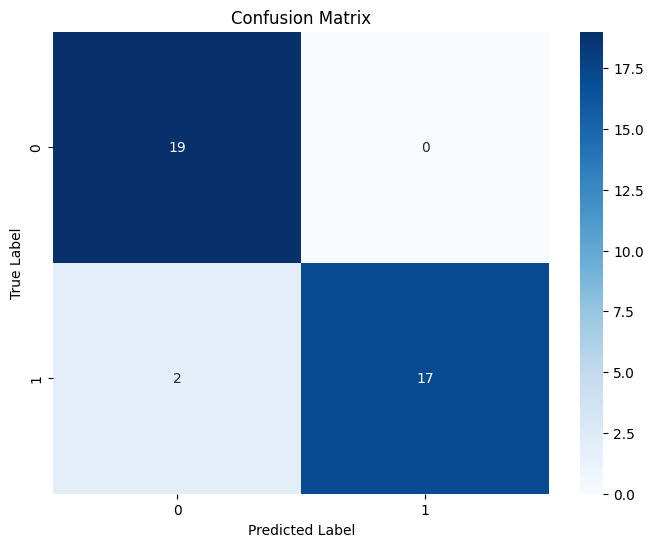

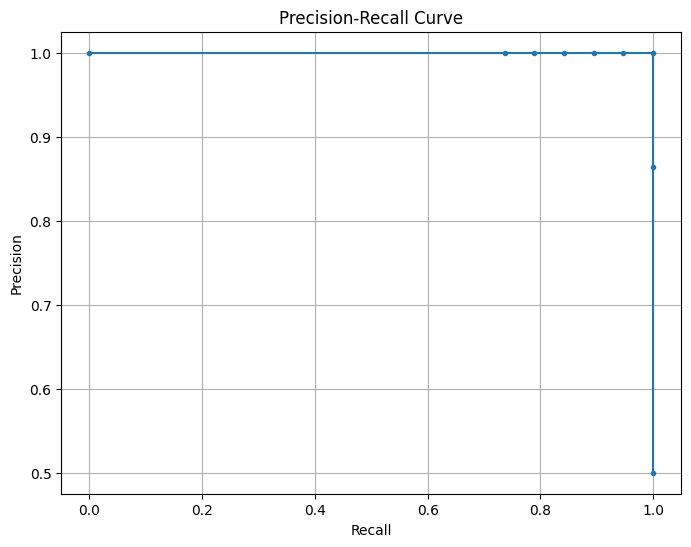

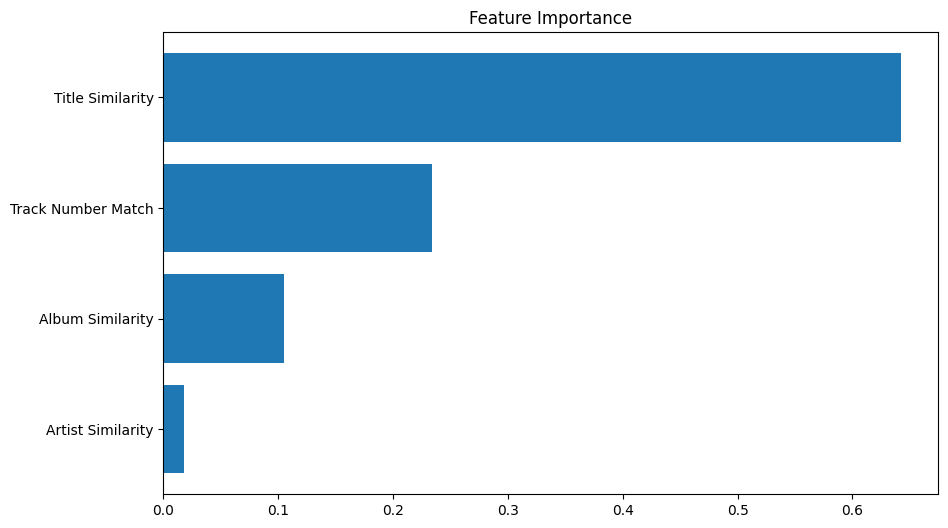

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Create features from your record pairs
def create_pair_features(records, pairs):
    """Create feature vectors for pairs of records."""
    features = []
    labels = []
    
    # Get ground truth
    true_clusters = df['CID'].to_dict()
    
    for rec_id1, rec_id2 in pairs:
        # Features - simple string similarity measures
        rec1 = records[rec_id1]
        rec2 = records[rec_id2]
        
        # Calculate Jaccard similarity for text fields
        def jaccard_sim(str1, str2):
            if not str1 or not str2:
                return 0
            set1 = set(str1.split())
            set2 = set(str2.split())
            intersection = len(set1.intersection(set2))
            union = len(set1) + len(set2) - intersection
            return intersection / union if union > 0 else 0
        
        # Create feature vector
        feature_vector = [
            jaccard_sim(rec1['title'], rec2['title']),
            jaccard_sim(rec1['artist'], rec2['artist']),
            jaccard_sim(rec1['album'], rec2['album']),
            1.0 if rec1['number'] == rec2['number'] and rec1['number'] != "MISSING" else 0.0
        ]
        features.append(feature_vector)
        
        # Label (1 if same entity, 0 if different)
        same_entity = true_clusters[rec_id1] == true_clusters[rec_id2]
        labels.append(1 if same_entity else 0)
    
    return np.array(features), np.array(labels)

# Step 2: Generate a sample of record pairs
def generate_record_pairs(records, sample_size=10000):
    """Generate a sample of record pairs for evaluation."""
    record_ids = list(records.keys())
    n_records = len(record_ids)
    
    # Get ground truth
    true_clusters = df['CID'].to_dict()
    
    # Create balanced sample of matching and non-matching pairs
    match_pairs = []
    non_match_pairs = []
    
    # Group records by CID
    cid_to_records = defaultdict(list)
    for rec_id, cid in true_clusters.items():
        cid_to_records[cid].append(rec_id)
    
    # Generate matching pairs
    for cid, rec_ids in cid_to_records.items():
        if len(rec_ids) >= 2:
            pairs = [(rec_ids[i], rec_ids[j]) 
                    for i in range(len(rec_ids)) 
                    for j in range(i+1, len(rec_ids))]
            match_pairs.extend(pairs)
    
    # Generate non-matching pairs
    while len(non_match_pairs) < min(sample_size // 2, len(match_pairs)):
        i, j = np.random.choice(n_records, 2, replace=False)
        rec_id1 = record_ids[i]
        rec_id2 = record_ids[j]
        if true_clusters[rec_id1] != true_clusters[rec_id2]:
            non_match_pairs.append((rec_id1, rec_id2))
    
    # Combine and shuffle
    all_pairs = match_pairs[:min(sample_size // 2, len(match_pairs))] + non_match_pairs
    np.random.shuffle(all_pairs)
    
    return all_pairs

# Step 3: Generate data and train model
print("Generating record pairs for ML evaluation...")
record_pairs = generate_record_pairs(records)
X, y = create_pair_features(records, record_pairs)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a random forest classifier
print("Training Random Forest classifier...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Step 4: Evaluate the classifier
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved to 'confusion_matrix.png'")

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.savefig('precision_recall_curve.png')
print("Precision-recall curve saved to 'precision_recall_curve.png'")

# Feature importance
plt.figure(figsize=(10, 6))
feature_names = ['Title Similarity', 'Artist Similarity', 'Album Similarity', 'Track Number Match']
importances = clf.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
print("Feature importance plot saved to 'feature_importance.png'")

# Compare with dedupe results
dedupe_pairs = set()
for cluster_id, cluster in enumerate(predicted_clusters.values()):
    cluster_records = [rec_id for rec_id, c_id in predicted_clusters.items() if c_id == cluster_id]
    for i in range(len(cluster_records)):
        for j in range(i+1, len(cluster_records)):
            dedupe_pairs.add((min(cluster_records[i], cluster_records[j]), 
                              max(cluster_records[i], cluster_records[j])))

print("\nComparison with dedupe results:")
print(f"Total record pairs evaluated by ML: {len(record_pairs)}")
print(f"Total record pairs linked by dedupe: {len(dedupe_pairs)}")

# Calculate precision and recall against ground truth
true_match_pairs = set()
for cid, rec_ids in cid_to_records.items():
    for i in range(len(rec_ids)):
        for j in range(i+1, len(rec_ids)):
            true_match_pairs.add((min(rec_ids[i], rec_ids[j]), 
                                  max(rec_ids[i], rec_ids[j])))


dedupe_true_positives = dedupe_pairs.intersection(true_match_pairs)
dedupe_precision = len(dedupe_true_positives) / len(dedupe_pairs) if dedupe_pairs else 0
dedupe_recall = len(dedupe_true_positives) / len(true_match_pairs) if true_match_pairs else 0
dedupe_f1 = 2 * (dedupe_precision * dedupe_recall) / (dedupe_precision + dedupe_recall) if (dedupe_precision + dedupe_recall) > 0 else 0

print("\nDedupe Performance Metrics:")
print(f"Precision: {dedupe_precision:.4f}")
print(f"Recall: {dedupe_recall:.4f}")
print(f"F1 Score: {dedupe_f1:.4f}")